In [30]:
import pandas as pd
import numpy as np
from collections import Counter

In [31]:
train_df = pd.read_csv('data/train_sent_emo.csv')
train_df.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [125]:
emotion_counts = Counter(train_df['Emotion'])
for e in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True):
    print(*e)

neutral 4710
joy 1743
surprise 1205
anger 1109
sadness 683
disgust 271
fear 268


In [34]:
test_df = pd.read_csv('data/test_sent_emo.csv')
test_df.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [35]:
# Determine zero rule baseline on test labels
total_labels = len(test_df['Emotion'])
c = Counter(test_df['Emotion'])
prediction = max(c, key=lambda k: c[k])
accuracy = c[prediction] / total_labels * 100
print(f'predict=: {prediction}. accuracy= {cntr[prediction]} / {total_labels} or {accuracy:.2f}%')

predict=: neutral. accuracy= 4710 / 2610 or 48.12%


In [36]:
def add_dia_utt(dataframe):
    # feature vectors are stored by 'dia_utt' so create that in the df
    cols = ['Dialogue_ID', 'Utterance_ID']
    dataframe['dia_utt'] = dataframe[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

add_dia_utt(train_df)
train_df['dia_utt']

0           0_0
1           0_1
2           0_2
3           0_3
4           0_4
         ...   
9984    1038_13
9985    1038_14
9986    1038_15
9987    1038_16
9988    1038_17
Name: dia_utt, Length: 9989, dtype: object

In [37]:
train_df.count()

Sr No.          9989
Utterance       9989
Speaker         9989
Emotion         9989
Sentiment       9989
Dialogue_ID     9989
Utterance_ID    9989
Season          9989
Episode         9989
StartTime       9989
EndTime         9989
dia_utt         9989
dtype: int64

__audio_embeddings_feature_selection_emotion.pkl__

__audio_embeddings_feature_selection_sentiment.pkl__ 

These consist of 1611 dimensional audio feature vectors of each utterance trained for emotion/sentiment classification. These features are originally extracted from openSMILE and then followed by L2-based feature selection using SVM. It is a list comprising of 3 dictionaries for train, val and the test set with each dictionary indexed in the format dia_utt, where dia is the dialogue id and utt is the utterance id. For eg. train_audio_emb['0_0'].shape = (1611, )

In [43]:
import pickle

fpath = 'data/audio_embeddings_feature_selection_emotion.pkl'

with open(fpath, 'rb') as f:
    splits = pickle.load(f)
    train_audio_emb, val_audio_emb, test_audio_emb = splits

In [44]:
for d in splits:
    print(len(d))

9989
1109
2610


In [45]:
sample_val = train_audio_emb['0_0']
len(sample_val)

1611

In [46]:

# check size of feature vectors
for emb in splits:
    print(Counter(len(v) for v in emb.values()))

Counter({1611: 9989})
Counter({1611: 1109})
Counter({1611: 2610})


In [47]:
type(sample_val)

numpy.ndarray

In [50]:
# check for nan
for ds, emb in zip(('train', 'val', 'test'), splits):
    hasNan = any(np.isnan(np.sum(v)) for v in emb.values())
    print(f'{ds} {hasNan}')
    assert not hasNan

train False
val False
test False


In [78]:
# want to ensure the labels and the feature vectors match up
assert len(df['dia_utt']) == len(train_audio_emb), 'train label count unequal to train feature vectors'

In [80]:
# assert every key in the labels has a corresponding feature key
feature_keys = set(train_audio_emb)
assert all(k in feature_keys for k in df['dia_utt'])

__Must convert the emotion labels to numeric. Use ordinal encoding__


In [145]:
from sklearn.preprocessing import OrdinalEncoder

labels = np.asarray(train_df['Emotion']).reshape(-1, 1)
encoder = OrdinalEncoder()
y_train = encoder.fit_transform(labels)

sample = 20
for a, b in zip(labels[:sample], y_train[:sample]):
    print(a[0], b[0])
    
y_train.shape

neutral 4.0
neutral 4.0
neutral 4.0
neutral 4.0
surprise 6.0
neutral 4.0
neutral 4.0
neutral 4.0
neutral 4.0
neutral 4.0
fear 2.0
neutral 4.0
surprise 6.0
neutral 4.0
surprise 6.0
sadness 5.0
surprise 6.0
fear 2.0
neutral 4.0
neutral 4.0


(9989, 1)

In [148]:
sample_val

array([0.57997844, 0.97480089, 0.15641021, ..., 0.21155205, 0.46432428,
       0.2308289 ])

In [117]:
# df['audio_features'] = df['dia_utt']
# df['audio_features'] = df['audio_features'].map(train_audio_emb)
# df['audio_features']

0       [0.579978439650127, 0.9748008896749043, 0.1564...
1       [0.28147418892256576, 0.0, 0.12441514993438094...
2       [0.5014279709337522, 0.0, 0.058416431345751405...
3       [0.1388128533473851, 0.0, 0.08666499619317054,...
4       [0.25864073256920134, 0.0, 0.20901806323479546...
                              ...                        
9984    [0.2417414004975775, 0.9093490972563685, 0.062...
9985    [0.4842651681687178, 0.0, 0.11541309428669909,...
9986    [0.5233553696735176, 0.0, 0.2133521777759187, ...
9987    [0.8594383850654352, 0.0, 0.6220717276650923, ...
9988    [0.9869913859161842, 0.6145796926996386, 0.182...
Name: audio_features, Length: 9989, dtype: object

In [146]:
X_train = np.array([train_audio_emb[x] for x in train_df['dia_utt']])
X_train.shape

(9989, 1611)

In [125]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [130]:
add_dia_utt(test_df)
test_df['dia_utt']

0          0_0
1          0_1
2          0_2
3          1_0
4          1_1
         ...  
2605    279_11
2606    279_12
2607    279_13
2608    279_14
2609    279_15
Name: dia_utt, Length: 2610, dtype: object

In [131]:
X_test = np.array([test_audio_emb[x] for x in test_df['dia_utt']])
X_test.shape

(2610, 1611)

In [138]:
pred_test = clf.predict(X_test)
pred_test

array([0., 4., 0., ..., 0., 3., 4.])

In [137]:
test_labels = np.asarray(test_df['Emotion']).reshape(-1, 1)
y_test = encoder.fit_transform(test_labels) 
y_test

array([[6.],
       [0.],
       [4.],
       ...,
       [4.],
       [4.],
       [4.]])

In [139]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_test, normalize=True)

0.2421455938697318

__Quick Dim Reduction for GCP__

In [195]:
from sklearn import cluster

train_feats = np.array([train_audio_emb[x] for x in train_df['dia_utt']])
test_feats = np.array([test_audio_emb[x] for x in test_df['dia_utt']])

agglo = cluster.FeatureAgglomeration(n_clusters=400) # rougly 1/4 orginal count
agglo.fit(train_feats)

X_train_reduced = agglo.transform(train_feats)
print(X_train_reduced.shape)

X_test_reduced = agglo.transform(test_feats)
print(X_test_reduced.shape)

(9989, 400)
(2610, 400)


__Export CSV__

In [205]:
# combining train features and labels into 1 CSV for auto ML testing
temp1 = pd.DataFrame(X_train_reduced)
temp2 = train_df[['Emotion']]

train_out = pd.concat([temp1, temp2], axis=1, ignore_index=True)

train_out.rename(columns={400:'target'}, inplace=True)
train_out.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,target
0,0.866356,0.614324,0.185344,0.111245,0.648110,0.578526,0.310698,0.152067,0.674275,0.442923,...,0.968448,0.224236,0.653971,0.717273,0.627245,0.388492,0.985613,0.311949,0.780483,neutral
1,0.243612,0.505836,0.535198,0.161876,0.447502,0.226764,0.244084,0.231661,0.239147,0.658598,...,0.345272,0.465961,0.338253,0.757522,0.324574,0.493105,0.331571,0.635806,0.263701,neutral
2,0.492822,0.384429,0.047081,0.670914,0.622658,0.485583,0.188774,0.921643,0.487226,0.546144,...,0.313540,0.656917,0.473370,0.292813,0.255299,0.369913,0.473489,0.878479,0.473124,neutral
3,0.357869,0.456488,0.085393,0.099274,0.712595,0.175410,0.180970,0.811440,0.229033,0.573145,...,0.567901,0.152608,0.997614,0.299942,0.476902,0.264865,0.654398,0.578228,0.426295,neutral
4,0.045266,0.383779,0.038214,0.042278,0.714882,0.040906,0.181542,0.898459,0.046304,0.432964,...,0.125052,0.085763,0.160444,0.933145,0.186585,0.548695,0.109561,0.061698,0.456410,surprise


In [206]:
train_out.to_csv('data/train_out.csv', index=False)

In [207]:
# combine test features / labels into 1 CSV for auto ML testing
temp1 = pd.DataFrame(X_test_reduced)
temp2 = test_df[['Emotion']]

test_out = pd.concat([temp1, temp2], axis=1, ignore_index=True)

test_out.rename(columns={400: 'target'}, inplace=True)
test_out.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,target
0,0.366837,0.489585,0.304097,0.387441,0.564342,0.057354,0.248615,0.670358,0.309868,0.625212,...,0.908848,0.188460,0.348473,0.798020,0.343952,0.579691,0.701661,0.083819,0.194004,surprise
1,0.202844,0.734532,0.427303,0.020722,0.716076,0.208896,0.501804,0.122180,0.080992,0.489508,...,0.010371,0.501315,0.102205,0.718053,0.784799,0.308052,0.809099,0.254798,0.725492,anger
2,0.795905,0.333515,0.255933,0.308112,0.686258,0.650555,0.153213,0.869954,0.791233,0.598061,...,0.659105,0.675327,0.633307,0.556018,0.419217,0.382399,0.633581,0.496429,0.017109,neutral
3,0.807803,0.386059,0.351130,0.491587,0.785491,0.948802,0.138051,0.820162,0.435799,0.699574,...,0.956317,0.672169,0.715221,0.376253,0.933253,0.361340,0.715530,0.843297,0.654712,neutral
4,0.618324,0.400439,0.323686,0.325977,0.816765,0.812821,0.123878,0.895026,0.658316,0.569047,...,0.580578,0.430384,0.565957,0.884793,0.710847,0.537625,0.551684,0.769204,0.130550,joy


In [208]:
test_out.to_csv('data/test_out.csv', index=False)

# Audio File Analysis

In [9]:
import os
meld_path = '/Users/home/Desktop/ml-eng/datasets/MELD'
meld_audio_rel_path = 'MELD.Raw/train/train_splits'
audio_path = os.path.join(meld_path, meld_audio_rel_path)
paths = [os.path.join(audio_path, fname) for fname in os.listdir(audio_path)]
len(paths)

9989

### convert mp4 to mp3

In [19]:
import moviepy.editor as mp

out_path = 'data/audio/'
finished = set(x.split('.')[0] for x in os.listdir(out_path))

fails = []
for path in paths:
    fname = path.split('/')[-1].split('.')[0]
    if fname in finished:
        continue
        
    print('processing: ' + fname)
    
    try:
        clip = mp.VideoFileClip(path)

        # pick highest quality based on https://zulko.github.io/moviepy/ref/AudioClip.html
        clip.audio.write_audiofile(out_path + fname + '.wav', nbytes=4, codec='pcm_s32le', bitrate='3000k')
    except Exception as e:
        fails.append(e)
        

print(f'fails {fails}')

processing: dia125_utt3
fails [OSError('MoviePy error: failed to read the duration of file /Users/home/Desktop/ml-eng/datasets/MELD/MELD.Raw/train/train_splits/dia125_utt3.mp4.\nHere are the file infos returned by ffmpeg:\n\nffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers\n  built with Apple clang version 11.0.0 (clang-1100.0.33.8)\n  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-l

In [42]:
paths = [os.path.join(out_path, fname) for fname in os.listdir(out_path)]
print(len(paths), paths[:10])

9988 ['data/audio/dia808_utt0.wav', 'data/audio/dia498_utt0.wav', 'data/audio/dia135_utt4.wav', 'data/audio/dia821_utt7.wav', 'data/audio/dia750_utt2.wav', 'data/audio/dia722_utt9.wav', 'data/audio/dia536_utt2.wav', 'data/audio/dia352_utt4.wav', 'data/audio/dia820_utt7.wav', 'data/audio/dia809_utt0.wav']


In [80]:
from random import sample
import librosa


def path_to_id(path: str) -> str:
    return path.split('/')[-1].split('.')[0].replace('dia', '').replace('utt', '')

audios = {}
srs = set()
sample_size = 100
for path in sample(paths, sample_size):
    audio, sr = librosa.load(path)
    audios[path_to_id(path)] = audio
    srs.add(sr)
    
print(srs)

{22050}


In [71]:
audios

{'537_2': array([-0.03114207, -0.06648594, -0.07587507, ...,  0.00292149,
        -0.00496776,  0.        ], dtype=float32)}

In [73]:
mapping = {row['dia_utt']: row['Emotion'] for i, row in train_df.iterrows()}
mapping

{'0_0': 'neutral',
 '0_1': 'neutral',
 '0_2': 'neutral',
 '0_3': 'neutral',
 '0_4': 'surprise',
 '0_5': 'neutral',
 '0_6': 'neutral',
 '0_7': 'neutral',
 '0_8': 'neutral',
 '0_9': 'neutral',
 '0_10': 'fear',
 '0_11': 'neutral',
 '0_12': 'surprise',
 '0_13': 'neutral',
 '1_0': 'surprise',
 '1_1': 'sadness',
 '1_2': 'surprise',
 '1_3': 'fear',
 '1_4': 'neutral',
 '1_5': 'neutral',
 '1_8': 'neutral',
 '2_0': 'neutral',
 '2_1': 'neutral',
 '2_2': 'joy',
 '2_3': 'sadness',
 '2_4': 'surprise',
 '2_5': 'neutral',
 '2_6': 'disgust',
 '2_7': 'sadness',
 '2_8': 'neutral',
 '2_9': 'neutral',
 '2_10': 'joy',
 '2_11': 'neutral',
 '2_12': 'joy',
 '3_0': 'surprise',
 '3_1': 'surprise',
 '3_2': 'surprise',
 '3_3': 'neutral',
 '3_4': 'neutral',
 '3_5': 'neutral',
 '3_6': 'surprise',
 '3_8': 'sadness',
 '3_9': 'neutral',
 '4_0': 'surprise',
 '4_1': 'joy',
 '4_2': 'surprise',
 '4_3': 'neutral',
 '4_4': 'neutral',
 '4_5': 'neutral',
 '4_6': 'neutral',
 '4_7': 'neutral',
 '4_8': 'joy',
 '4_9': 'joy',
 '4_1

In [77]:
for k in audios:
    assert k in mapping, k

## EDA of audio files

min 3087


(array([26., 36., 50., 91., 65., 57., 37., 26., 15., 11., 17., 12., 11.,
         9., 10.,  3.,  8.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  3.,  0.,
         0.,  1.,  0.,  1.]),
 array([  3087.,  14406.,  25725.,  37044.,  48363.,  59682.,  71001.,
         82320.,  93639., 104958., 116277., 127596., 138915., 150234.,
        161553., 172872., 184191., 195510., 206829., 218148., 229467.,
        240786., 252105., 263424., 274743., 286062., 297381., 308700.,
        320019., 331338., 342657.]),
 <BarContainer object of 30 artists>)

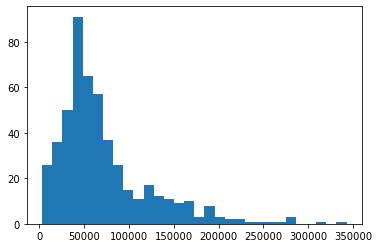

In [64]:
import matplotlib.pyplot as plt

lengths = np.array([len(v) for v in audios.values()])
print(f'min {min(lengths)}')
plt.hist(lengths, bins=30)

EDA
obtain 10 samples of each emotion 
calculate the coefficients (e.g., 10) to go from a time series to a spectogram
put the features through PCA, are there any clusters?

https://stackoverflow.com/questions/56911774/mfcc-feature-extraction-librosa
https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/

Questions to answer
- what length audio file is optimal?
- what features are useful?

### Mel-scaled spectrogram

- time-frequency representation of sound
- sampled into a number of points around equally spaced times and frequencies on a Mel frequency scale
- Mel frequency scale: mel = 2595 * log10 (1 + hertz / 700)
- constructed such that sounds of equal distance from each other on the Mel Scale, also sound to humans as they are equal distance from on another
- in contrast to Hz scale where 500-1000 hz is obvious but 7500 to 8000 barely noticeable


id  572_14 
size  42336 
label  neutral


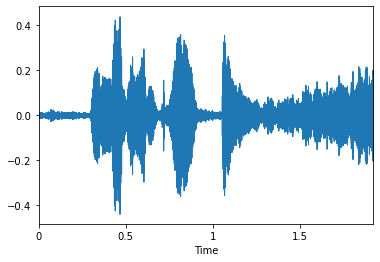

In [83]:
from librosa.display import waveplot

sr=22050
dia_utt, y = next(iter(audios.items()))
print('id ', dia_utt, '\nsize ', len(y), '\nlabel ', mapping[dia_utt])

waveplot(y, sr=sr)

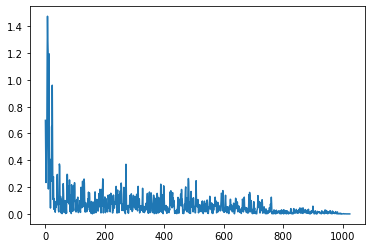

In [88]:
# apply FFT

import numpy as np
import matplotlib.pyplot as plt

n_fft = 2048
D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
plt.plot(D)

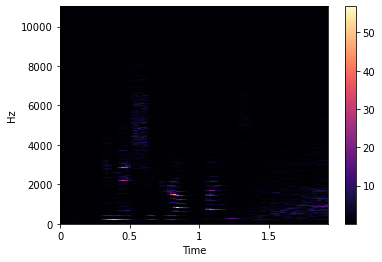

In [89]:
# FFT + time windows
hop_length = 512
D = np.abs(librosa.stft(y, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

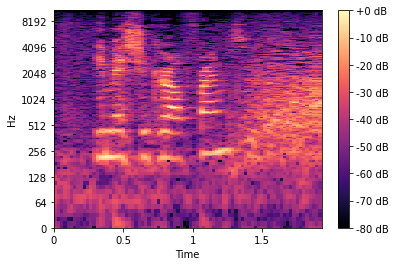

In [90]:
# transformed to DB
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

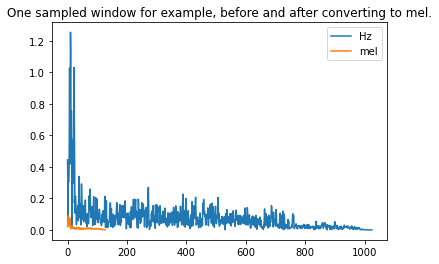

In [95]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.');

(128, 83)
(128, 83)


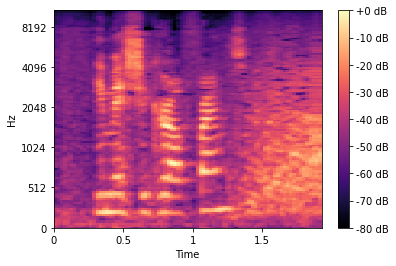

In [100]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_db = librosa.power_to_db(S, ref=np.max)
print(S.shape)
print(S_db.shape)

librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

Recap
- Separate to windows: Sample the input with windows of size n_fft=2048, making hops of size hop_length=512 each time to sample the next window.
- Compute FFT (Fast Fourier Transform) for each window to transform from time domain to frequency domain.
- Generate a Mel scale: Take the entire frequency spectrum, and separate it into n_mels=128 evenly spaced frequencies.
- And what do we mean by evenly spaced? not by distance on the frequency dimension, but distance as it is heard by the human ear.
- Generate Spectrogram: For each window, decompose the magnitude of the signal into its components, corresponding to the frequencies in the mel scale.

source: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

### Mel-frequency cepstral coefficients (MFCCs)

- representation of the short-term power spectrum of a sound based on a linear cosine transform of a log power spectrum on a mel scale of frequency
- Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.[1] They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression
(https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

- small set of features (usually 10-20) which concisely describe the overall shape of a spectral envelope

In [102]:
import IPython
IPython.display.Audio(y, rate=sr)

In [104]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print('{} MFCCs over {} frames'.format(*mfccs.shape))

20 MFCCs over 83 frames


The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. Therefore, many practitioners will discard the first MFCC when performing classification. For now, we will use the MFCCs as is.
(source: https://musicinformationretrieval.com/mfcc.html)

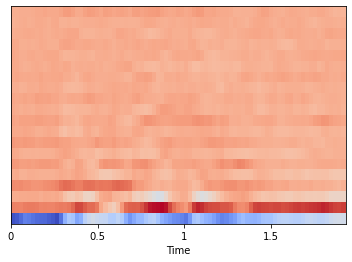

In [106]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [110]:
# feature scaling to mean 0 and variance 1
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))  # close to 0
print(mfccs.var(axis=1))  # close to 1

[ 4.3087693e-09  1.5798822e-08 -7.1812827e-09  7.1812827e-09
  1.0053795e-08  2.8725129e-09 -7.8994109e-09 -1.4362564e-09
 -1.4362564e-09 -6.4631545e-09 -3.5906413e-09  4.3087693e-09
 -7.1812822e-10 -7.9891764e-09 -2.8725129e-09  4.3087693e-09
  3.9497055e-09  0.0000000e+00  8.9766035e-09 -8.6175387e-09]
[0.9999998 0.9999999 1.        1.        1.        1.0000001 0.9999999
 0.9999998 1.0000001 1.        0.9999999 1.0000002 1.        1.0000002
 1.0000001 1.0000001 0.9999999 0.9999999 1.        1.       ]


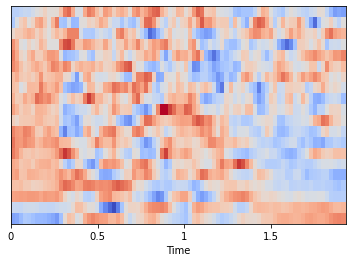

In [111]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [120]:
def extract_features(y, sr, mfcc=True, n_mfcc=20, chroma=True, mel=True):
    result = np.array([])
    if mfcc:
        X = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
        result = np.hstack((result, X))
    
    if chroma: 
        stft = np.abs(librosa.stft(y))
        X = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, X))
        
    if mel:
        X = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
        result = np.hstack((result, X))
    
    return result
    

In [123]:
extract_features(y, sr, chroma=False, mel=False).shape

(20,)

In [121]:
extract_features(y, sr, mfcc=False, chroma=True, mel=False).shape

(12,)

In [122]:
extract_features(y, sr, mfcc=False, chroma=False, mel=True).shape

(128,)

In [127]:
emotions = {str(i): k for i, k in enumerate(emotion_counts)}
emotions

{'0': 'neutral',
 '1': 'surprise',
 '2': 'fear',
 '3': 'sadness',
 '4': 'joy',
 '5': 'disgust',
 '6': 'anger'}

In [134]:
# summary 
# the raw train audio is stored in audios, indexed by dia_utt
print(next(iter(audios.items())))
# the train labels are stored in  train_df
print(train_df['Emotion'].head(3))

('572_14', array([ 0.0007416 , -0.00259174, -0.00518135, ...,  0.00483236,
        0.00538473,  0.0045601 ], dtype=float32))
0    neutral
1    neutral
2    neutral
Name: Emotion, dtype: object


In [136]:
# loop through the DF and create a mapping from dia_utt to emotion label
id_to_label = {}
for i, r in train_df.iterrows():
    id_to_label[r['dia_utt']] = r['Emotion']
list(id_to_label.items

{'0_0': 'neutral',
 '0_1': 'neutral',
 '0_2': 'neutral',
 '0_3': 'neutral',
 '0_4': 'surprise',
 '0_5': 'neutral',
 '0_6': 'neutral',
 '0_7': 'neutral',
 '0_8': 'neutral',
 '0_9': 'neutral',
 '0_10': 'fear',
 '0_11': 'neutral',
 '0_12': 'surprise',
 '0_13': 'neutral',
 '1_0': 'surprise',
 '1_1': 'sadness',
 '1_2': 'surprise',
 '1_3': 'fear',
 '1_4': 'neutral',
 '1_5': 'neutral',
 '1_8': 'neutral',
 '2_0': 'neutral',
 '2_1': 'neutral',
 '2_2': 'joy',
 '2_3': 'sadness',
 '2_4': 'surprise',
 '2_5': 'neutral',
 '2_6': 'disgust',
 '2_7': 'sadness',
 '2_8': 'neutral',
 '2_9': 'neutral',
 '2_10': 'joy',
 '2_11': 'neutral',
 '2_12': 'joy',
 '3_0': 'surprise',
 '3_1': 'surprise',
 '3_2': 'surprise',
 '3_3': 'neutral',
 '3_4': 'neutral',
 '3_5': 'neutral',
 '3_6': 'surprise',
 '3_8': 'sadness',
 '3_9': 'neutral',
 '4_0': 'surprise',
 '4_1': 'joy',
 '4_2': 'surprise',
 '4_3': 'neutral',
 '4_4': 'neutral',
 '4_5': 'neutral',
 '4_6': 'neutral',
 '4_7': 'neutral',
 '4_8': 'joy',
 '4_9': 'joy',
 '4_1

In [137]:
# construct X_train, y_train
X_train = []
y_train = []
for dia_utt, signal in audios.items():
    X_train.append(extract_features(signal, sr))
    y_train.append(id_to_label[dia_utt]) 
    
X_train = np.array(X_train)
print(X_train.shape)

y_train = np.array(y_train)
print(y_train.shape)

(100, 160)
(100,)


In [139]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)  # inverse_transform to get labels
y_train

array([3, 2, 3, 3, 2, 3, 0, 3, 0, 3, 2, 3, 0, 3, 3, 5, 0, 3, 3, 3, 3, 0,
       0, 3, 3, 3, 3, 4, 0, 0, 3, 3, 2, 3, 3, 3, 4, 2, 2, 2, 3, 3, 0, 0,
       4, 2, 4, 3, 0, 2, 2, 5, 5, 4, 5, 3, 0, 3, 0, 2, 2, 4, 4, 2, 2, 1,
       0, 1, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 2, 5, 1, 4, 0, 0,
       2, 5, 4, 2, 3, 5, 3, 3, 0, 0, 3, 3])